In [1]:
data = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'

In [2]:
!wget $data

--2024-10-16 10:11:10--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [    <=>             ] 999.85K  1.05MB/s    in 0.9s    

2024-10-16 10:11:12 (1.05 MB/s) - ‘bank+marketing.zip’ saved [1023843]



In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('bank-full.csv', sep=';')

In [7]:
df = df[['age', 'job', 'marital', 'education', 'balance', 'housing',
       'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y']]

In [8]:
df.y = df.y.replace({'yes': 1, 'no':0})

/tmp/ipykernel_28519/2032539318.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.y = df.y.replace({'yes': 1, 'no':0})


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [11]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [12]:
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [15]:
del df_train['y']
del df_val['y']
del df_test['y']

In [16]:
df.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

In [17]:
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [18]:
from sklearn.feature_extraction import DictVectorizer

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [21]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [22]:
y_pred = model.predict_proba(X_val)[:, 1]

### Question 1

In [23]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

In [24]:
fpr, tpr, thresholds = roc_curve(y_train, df_train['previous'])

In [25]:
auc(fpr, tpr)

np.float64(0.5985653242764153)

### Question 2

In [26]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [27]:
auc(fpr, tpr)

np.float64(0.9002510973902931)

### Question 3

In [28]:
import numpy as np

In [44]:
def presision_recall_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['f1'] = (2 * df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall'])

    return df_scores

In [45]:
df_scores = presision_recall_dataframe(y_val, y_pred)

In [46]:
df_scores.f1.max()

np.float64(0.5705756929637525)

In [49]:
df_scores[df_scores.f1 == df_scores.f1.max()]

,threshold,tp,fp,fn,tn,precision,recall,f1
23,0.23,669,578,429,7366,0.536488,0.60929,0.570576


In [50]:
df_scores[df_scores.threshold == 0.22]

,threshold,tp,fp,fn,tn,precision,recall,f1
22,0.22,685,620,413,7324,0.524904,0.623862,0.570121


In [33]:
import matplotlib.pyplot as plt

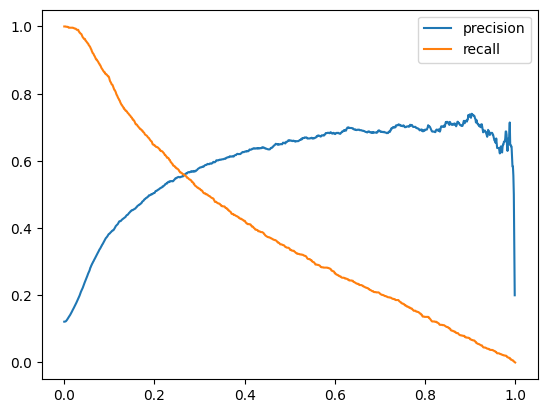

In [34]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

### Question 4